In [ ]:
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')
with zipfile.ZipFile('/content/drive/MyDrive/Dataset_Bersih.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np
import joblib

# Path ke direktori dataset
dataset_dir = '/content/Dataset Bersih'

# Memuat dataset
full_dataset = image_dataset_from_directory(dataset_dir,
                                            labels='inferred',
                                            label_mode='int',
                                            class_names=['mel', 'bcc', 'norm'],
                                            image_size=(224, 224),
                                            batch_size=32,
                                            shuffle=True)


Found 1725 files belonging to 3 classes.


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import DenseNet201

base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

# Menambahkan GlobalAveragePooling2D layer untuk mendapatkan vektor fitur
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D()
])

base_model.summary()

def extract_features(dataset):
    features = []
    labels = []
    for images, lbls in dataset:
        preprocessed_images = preprocess_input(images)
        feats = model.predict(preprocessed_images)
        features.append(feats)
        labels.append(lbls.numpy())
    return np.concatenate(features), np.concatenate(labels)

full_features, full_labels = extract_features(full_dataset)


74836368/74836368 [==============================] - 1s 0us/step
Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormali

In [ ]:
import pandas as pd  # Impor pandas
# Menampilkan hasil ekstraksi fitur menggunakan DataFrame
# feature_names = [f"feature_{i}" for i in range(full_features.shape[1])]
# df = pd.DataFrame(data=full_features, columns=feature_names)
# df['label'] = full_labels

# print(df)

# Feature names for DataFrame
feature_names = [f"feature_{i}" for i in range(full_features.shape[1])]

# Creating DataFrame from extracted features and labels
df = pd.DataFrame(data=full_features, columns=feature_names)
df['label'] = full_labels

# Function to map label integer to class name
def map_label(label):
    class_names = ['mel', 'bcc', 'norm']
    return class_names[label]

# Applying map_label function to convert labels to class names
df['label'] = df['label'].apply(map_label)

# Displaying DataFrame with better format
pd.set_option('display.max_columns', 10)  # Show all columns
pd.set_option('display.max_rows', 10)  # Limit the number of rows displayed
pd.set_option('display.float_format', lambda x: '%.4f' % x)  # Format float numbers

# Showing the first few rows of the DataFrame
print(df.head())

# Optionally, save the DataFrame to a CSV file for further analysis
df.to_csv('/content/extracted_features_Mobilenet.csv', index=False)

   feature_0  feature_1  feature_2  feature_3  feature_4  ...  feature_1916  \
0     0.0001     0.0003     0.0014     0.0039     0.0011  ...        0.5097   
1     0.0001     0.0003     0.0013     0.0004     0.0004  ...        0.1124   
2     0.0001     0.0003     0.0017     0.0031     0.0010  ...        0.5127   
3     0.0002     0.0006     0.0019     0.0007     0.0003  ...        0.0196   
4     0.0002     0.0005     0.0015     0.0007     0.0001  ...        1.7661   

   feature_1917  feature_1918  feature_1919  label  
0        0.0134        0.1137        0.0339    bcc  
1        0.1608        0.0170        0.0361    bcc  
2        0.0067        0.2409        0.2041    bcc  
3        0.0000        0.0000        0.0016   norm  
4        0.1231        0.5756        0.0000    mel  

[5 rows x 1921 columns]


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
# k = 5
# skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
# accuracies = []
# best_accuracy = 0
# best_model = None
# best_confusion_matrix = None
# best_classification_report = None

# for fold, (train_index, test_index) in enumerate(skf.split(full_features, full_labels)):
#     train_features, test_features = full_features[train_index], full_features[test_index]
#     train_labels, test_labels = full_labels[train_index], full_labels[test_index]

#     svm = SVC()
#     svm.fit(train_features, train_labels)

#     predictions = svm.predict(test_features)
#     accuracy = accuracy_score(test_labels, predictions)
#     accuracies.append(accuracy)

#     print(f'Fold {fold + 1}, Accuracy: {accuracy}')

#     if accuracy > best_accuracy:
#         best_accuracy = accuracy
#         best_model = svm
#         best_confusion_matrix = confusion_matrix(test_labels, predictions)
#         best_classification_report = classification_report(test_labels, predictions)
#         joblib.dump(best_model, 'best_svm_model.pkl')

# print(f'Average accuracy: {np.mean(accuracies)}, Best accuracy: {best_accuracy}')
# print("Best Confusion Matrix:")
# print(best_confusion_matrix)
# print("Best Classification Report:")
# print(best_classification_report)

k = 5  # Number of folds
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
accuracies = []
precisions = []
sensitivities = []
specificities = []
f1_scores = []
best_accuracy = 0
best_model = None
best_confusion_matrix = None
best_classification_report = None

for fold, (train_index, test_index) in enumerate(skf.split(full_features, full_labels)):
    train_features, test_features = full_features[train_index], full_features[test_index]
    train_labels, test_labels = full_labels[train_index], full_labels[test_index]

    svm = SVC()
    svm.fit(train_features, train_labels)

    predictions = svm.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)
    accuracies.append(accuracy)

    precision = precision_score(test_labels, predictions, average='weighted')
    precisions.append(precision)

    recall = recall_score(test_labels, predictions, average='weighted')
    sensitivities.append(recall)

    cm = confusion_matrix(test_labels, predictions)
    specificity = np.diag(cm) / np.sum(cm, axis=1)
    specificity = np.mean(specificity)
    specificities.append(specificity)

    f1 = f1_score(test_labels, predictions, average='weighted')
    f1_scores.append(f1)

    print(f'Fold {fold + 1}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Sensitivity: {recall:.4f}, Specificity: {specificity:.4f}, F1-score: {f1:.4f}')

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = svm
        best_confusion_matrix = cm
        best_classification_report = classification_report(test_labels, predictions)
        joblib.dump(best_model, 'best_svm_model.pkl')

average_accuracy = np.mean(accuracies)
average_precision = np.mean(precisions)
average_sensitivity = np.mean(sensitivities)
average_specificity = np.mean(specificities)
average_f1 = np.mean(f1_scores)

print(f'Average accuracy: {average_accuracy:.4f}, Best accuracy: {best_accuracy:.4f}')
print("Best Confusion Matrix:")
print(best_confusion_matrix)
print("Best Classification Report:")
print(best_classification_report)

print(f'Average Precision: {average_precision:.4f}')
print(f'Average Sensitivity: {average_sensitivity:.4f}')
print(f'Average Specificity: {average_specificity:.4f}')
print(f'Average F1-score: {average_f1:.4f}')


Fold 1, Accuracy: 0.8580, Precision: 0.8607, Sensitivity: 0.8580, Specificity: 0.8580, F1-score: 0.8573
Fold 2, Accuracy: 0.8696, Precision: 0.8706, Sensitivity: 0.8696, Specificity: 0.8696, F1-score: 0.8678
Fold 3, Accuracy: 0.8696, Precision: 0.8716, Sensitivity: 0.8696, Specificity: 0.8696, F1-score: 0.8697
Fold 4, Accuracy: 0.8580, Precision: 0.8615, Sensitivity: 0.8580, Specificity: 0.8580, F1-score: 0.8582
Fold 5, Accuracy: 0.9014, Precision: 0.9023, Sensitivity: 0.9014, Specificity: 0.9014, F1-score: 0.9012
Average accuracy: 0.8713, Best accuracy: 0.9014
Best Confusion Matrix:
[[ 97  14   4]
 [  4 107   4]
 [  6   2 107]]
Best Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87       115
           1       0.87      0.93      0.90       115
           2       0.93      0.93      0.93       115

    accuracy                           0.90       345
   macro avg       0.90      0.90      0.90       345
weighted 

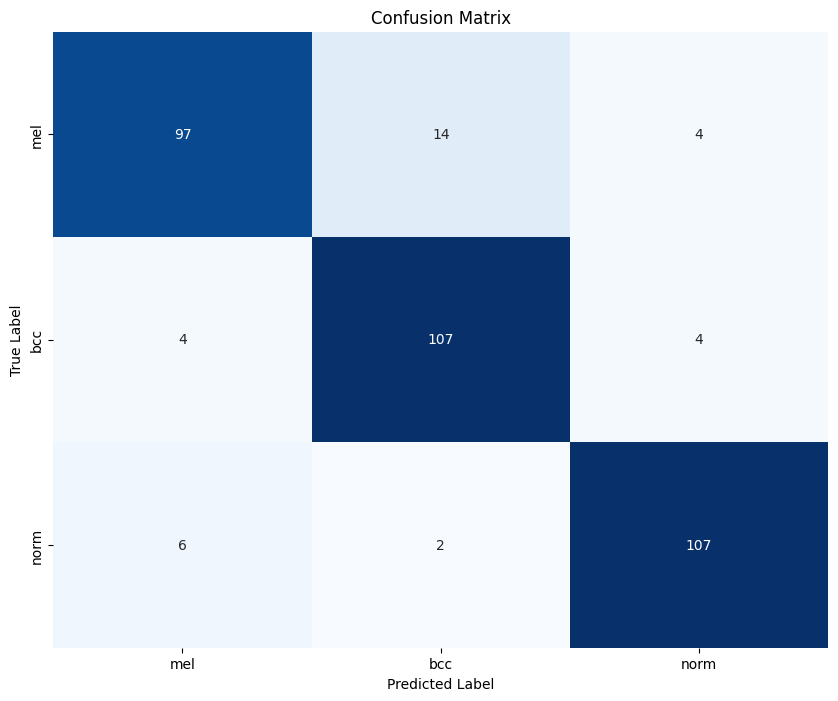

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Menampilkan Confusion Matrix dengan label yang tepat
plt.figure(figsize=(10, 8))
sns.heatmap(best_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

# Mendapatkan nama kelas dari variabel class_names
class_names = ['mel', 'bcc', 'norm']

# Menambahkan label ke sumbu x dan y
plt.xticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, ha='center')
plt.yticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, va='center')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# Memuat model SVM terbaik yang sudah disimpan sebelumnya
best_svm = joblib.load('best_svm_model.pkl')

# Parameter yang akan diuji
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

# Membuat objek GridSearchCV
grid_search = GridSearchCV(estimator=best_svm, param_grid=param_grid, cv=5, scoring='accuracy')

# Melakukan grid search
grid_search.fit(train_features, train_labels)

# Menampilkan parameter terbaik
print("Parameter terbaik:", grid_search.best_params_)


Parameter terbaik: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# Best parameters obtained from GridSearchCV
best_params = {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}

k = 5  # Number of folds
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
accuracies = []
precisions = []
sensitivities = []
specificities = []
f1_scores = []
best_accuracy = 0
best_model = None
best_confusion_matrix = None
best_classification_report = None

for fold, (train_index, test_index) in enumerate(skf.split(full_features, full_labels)):
    train_features, test_features = full_features[train_index], full_features[test_index]
    train_labels, test_labels = full_labels[train_index], full_labels[test_index]

    svm = SVC(**best_params)
    svm.fit(train_features, train_labels)

    predictions = svm.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)
    accuracies.append(accuracy)

    precision = precision_score(test_labels, predictions, average='weighted')
    precisions.append(precision)

    recall = recall_score(test_labels, predictions, average='weighted')
    sensitivities.append(recall)

    cm = confusion_matrix(test_labels, predictions)
    specificity = np.diag(cm) / np.sum(cm, axis=1)
    specificity = np.mean(specificity)
    specificities.append(specificity)

    f1 = f1_score(test_labels, predictions, average='weighted')
    f1_scores.append(f1)

    print(f'Fold {fold + 1}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Sensitivity: {recall:.4f}, Specificity: {specificity:.4f}, F1-score: {f1:.4f}')

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = svm
        best_confusion_matrix = cm
        best_classification_report = classification_report(test_labels, predictions)
        joblib.dump(best_model, 'best_svm_model_tuning.pkl')

average_accuracy = np.mean(accuracies)
average_precision = np.mean(precisions)
average_sensitivity = np.mean(sensitivities)
average_specificity = np.mean(specificities)
average_f1 = np.mean(f1_scores)

print(f'Average accuracy: {average_accuracy:.4f}, Best accuracy: {best_accuracy:.4f}')
print("Best Confusion Matrix:")
print(best_confusion_matrix)
print("Best Classification Report:")
print(best_classification_report)

print(f'Average Precision: {average_precision:.4f}')
print(f'Average Sensitivity: {average_sensitivity:.4f}')
print(f'Average Specificity: {average_specificity:.4f}')
print(f'Average F1-score: {average_f1:.4f}')


Fold 1, Accuracy: 0.8783, Precision: 0.8785, Sensitivity: 0.8783, Specificity: 0.8783, F1-score: 0.8779
Fold 2, Accuracy: 0.9072, Precision: 0.9073, Sensitivity: 0.9072, Specificity: 0.9072, F1-score: 0.9068
Fold 3, Accuracy: 0.9043, Precision: 0.9058, Sensitivity: 0.9043, Specificity: 0.9043, F1-score: 0.9044
Fold 4, Accuracy: 0.8725, Precision: 0.8726, Sensitivity: 0.8725, Specificity: 0.8725, F1-score: 0.8724
Fold 5, Accuracy: 0.9072, Precision: 0.9074, Sensitivity: 0.9072, Specificity: 0.9072, F1-score: 0.9069
Average accuracy: 0.8939, Best accuracy: 0.9072
Best Confusion Matrix:
[[ 97  12   6]
 [  5 109   1]
 [  7   1 107]]
Best Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.84      0.87       115
           1       0.89      0.95      0.92       115
           2       0.94      0.93      0.93       115

    accuracy                           0.91       345
   macro avg       0.91      0.91      0.91       345
weighted 

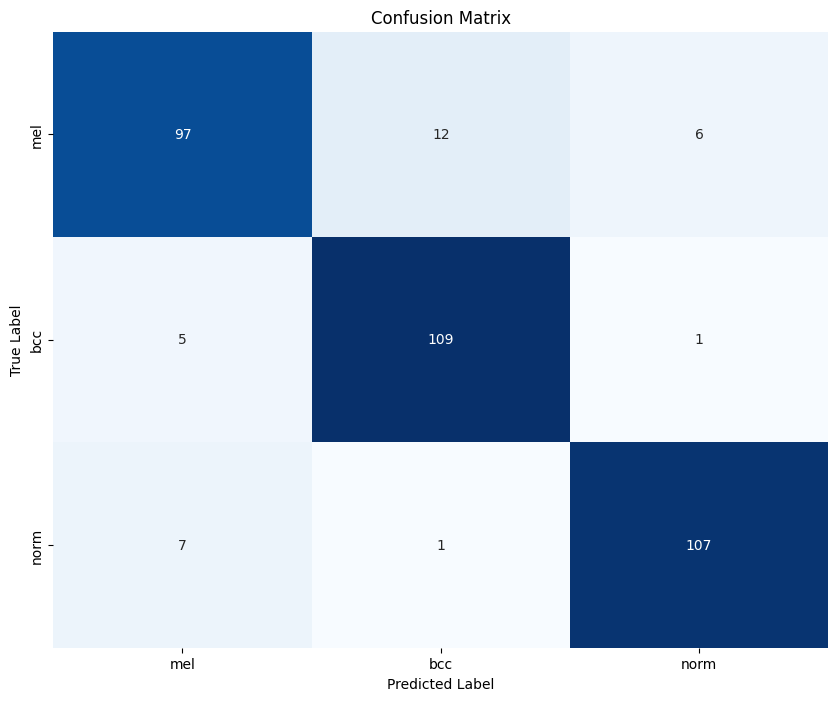

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Menampilkan Confusion Matrix dengan label yang tepat
plt.figure(figsize=(10, 8))
sns.heatmap(best_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

# Mendapatkan nama kelas dari variabel class_names
class_names = ['mel', 'bcc', 'norm']

# Menambahkan label ke sumbu x dan y
plt.xticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, ha='center')
plt.yticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, va='center')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()